In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from IPython import display

In [2]:
path = "rt-polaritydata/rt-polaritydata/"

pos_path = os.path.join(path, 'rt-polarity.pos')
neg_path = os.path.join(path, 'rt-polarity.neg')

def load_review(path, is_pos=True):
    with open(path) as f:
        review = pd.DataFrame({'review':f.read().splitlines()})
    review['sentiment'] = 1 if is_pos else 0
    return review

pos_review = load_review(pos_path, is_pos=True)
neg_review = load_review(neg_path, is_pos=False)

display.display(pos_review.head(), neg_review.head())

,review,sentiment
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


,review,sentiment
0,"simplistic , silly and tedious .",0
1,"it's so laddish and juvenile , only teenage bo...",0
2,exploitative and largely devoid of the depth o...,0
3,[garbus] discards the potential for pathologic...,0
4,a visually flashy but narratively opaque and e...,0


In [16]:
all_reviews = pd.concat([pos_review, neg_review])
all_reviews.head()

,review,sentiment
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


In [17]:
all_reviews["review_splitted"] = all_reviews.review.apply(lambda review: tf.keras.preprocessing.text.text_to_word_sequence(review))

In [20]:
import functools
import operator

def get_all_characters(df):
    chars = []
    for review in df.review_splitted:
        for word in review:
            chars.append(word)
    chars = functools.reduce(operator.iconcat, chars, [])
    return list(set(chars))

In [21]:
chars = get_all_characters(all_reviews)

NUM_CHARS = len(chars)
print('Total number of characters: {}\n{}'.format(NUM_CHARS, chars))

Total number of characters: 61
['e', 'ú', '4', 'z', 'j', 'ŕ', 'ć', 's', 'k', 'ô', '–', 'n', 'r', 'v', 'p', '—', 'ő', 'o', 'q', 'é', 'm', '8', 'h', '5', 'a', '7', 'ű', 'w', 't', '…', 'u', 'ď', '6', '1', 'ă', 'ç', 'â', 'í', '0', '3', '9', 'ń', '2', 'ó', 'g', 'l', 'f', '‘', 'á', 'i', 'ö', 'ę', 'ü', '˝', "'", 'c', 'č', 'b', 'x', 'y', 'd']


In [22]:
char_to_num = {chars[i]: i for i in range(NUM_CHARS)}
num_to_char = {i: chars[i] for i in range(NUM_CHARS)}

Find the maximum length of review -- padding

In [23]:
def get_max_len(df):
    all_lenghts = []
    for review in df.review:
        all_lenghts.append(len(list(review)))
    return max(all_lenghts)

In [27]:
MAX_LEN_POS = get_max_len(pos_review)
MAX_LEN_NEG = get_max_len(neg_review)

MAX_LEN_POS, MAX_LEN_NEG

(269, 267)

In [28]:
MAX_LEN = get_max_len(all_reviews)
print('Maximum length of review: {} (in characters)'.format(MAX_LEN))

Maximum length of review: 269 (in characters)


In [126]:
from stop_words import get_stop_words

def review_to_one_hot(char):
    one_hot = [0] * NUM_CHARS
    pos = char_to_num[char]
    one_hot[pos] = 1
    return one_hot

def process_review(review, pad=True, max_len=MAX_LEN):
    review = tf.keras.preprocessing.text.text_to_word_sequence(review)
    review = [word for word in review if word not in get_stop_words('english')]
    review = [list(s) for s in review] # to characters
    review = functools.reduce(operator.iconcat, review, [])
    review_one_hot = [review_to_one_hot(char) for char in review]
    if pad:
        # append 0 value padding
        while len(review_one_hot) < max_len:
            review_one_hot.append([0] * NUM_CHARS)
    review_one_hot = review_one_hot[:max_len] # trucate to max length
    return review_one_hot

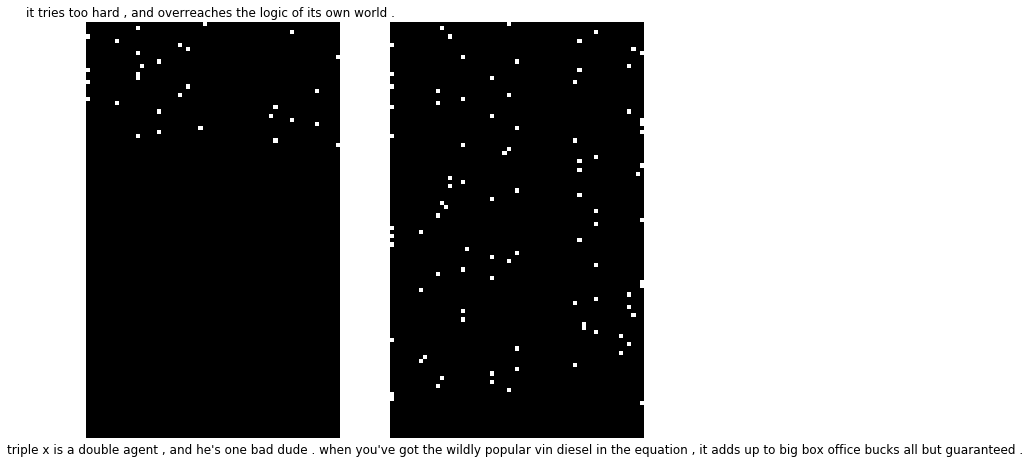

In [127]:
plt.figure(figsize=(10, 12))
plt.subplot(1, 2, 1)
plt.title(neg_review.review.iloc[2345])
plt.imshow([p for p in process_review(neg_review.review.iloc[2345], max_len=100)], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(pos_review.review.iloc[2345], y=-0.05)
plt.imshow([p for p in process_review(pos_review.review.iloc[2345], max_len=100)], cmap='gray')
plt.axis('off')

plt.show()

In [128]:
MAX_LEN_SEQ = 50 # in characters

processed_review = all_reviews.review.apply(lambda review: process_review(review, max_len=MAX_LEN_SEQ))

In [129]:
from sklearn.model_selection import train_test_split


X = processed_review.to_numpy().tolist()
y = all_reviews.sentiment.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [130]:
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)

In [131]:
X_train_reshaped = tf.reshape(X_train, [X_train.shape[0], X_train.shape[2], X_train.shape[1], 1]) # one channel (black or white)
X_test_reshaped = tf.reshape(X_test, [X_test.shape[0], X_test.shape[2], X_test.shape[1], 1])

In [132]:
X_train_reshaped.shape, X_test_reshaped.shape, y_train.shape, y_test.shape

(TensorShape([9595, 61, 50, 1]),
 TensorShape([1067, 61, 50, 1]),
 TensorShape([9595]),
 TensorShape([1067]))

In [152]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(NUM_CHARS, MAX_LEN_SEQ, 1)),
    tf.keras.layers.MaxPool2D((2, 2)),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPool2D((2, 2)),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Conv2D(64, (2, 2), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [153]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 59, 48, 32)        320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 29, 24, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 22272)             0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 22272)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               2850944   
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total params: 2,851,393
Trainable params: 2,851,393
Non-trainable params: 0
____________________________________________

In [154]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [155]:
BATCH_SIZE = 128

history = model.fit(X_train_reshaped, 
                    y_train, 
                    epochs=20, 
                    batch_size=BATCH_SIZE,
                    validation_data=(X_test_reshaped, y_test))

Train on 9595 samples, validate on 1067 samples
Epoch 1/20
9595/9595 [==============================] - 3s 292us/sample - loss: 0.6941 - accuracy: 0.5158 - val_loss: 0.6902 - val_accuracy: 0.5173
Epoch 2/20
9595/9595 [==============================] - 2s 227us/sample - loss: 0.6778 - accuracy: 0.5732 - val_loss: 0.6905 - val_accuracy: 0.5192
Epoch 3/20
9595/9595 [==============================] - 2s 227us/sample - loss: 0.6566 - accuracy: 0.6110 - val_loss: 0.7068 - val_accuracy: 0.5220
Epoch 4/20
9595/9595 [==============================] - 2s 228us/sample - loss: 0.6250 - accuracy: 0.6468 - val_loss: 0.7036 - val_accuracy: 0.5305
Epoch 5/20
9595/9595 [==============================] - 2s 227us/sample - loss: 0.5641 - accuracy: 0.7096 - val_loss: 0.7589 - val_accuracy: 0.5276
Epoch 6/20
9595/9595 [==============================] - 2s 227us/sample - loss: 0.4573 - accuracy: 0.7871 - val_loss: 0.8026 - val_accuracy: 0.5361
Epoch 7/20
9595/9595 [==============================] - 2s 230us

In [156]:
def predict(review, max_len=MAX_LEN_SEQ, shape=(MAX_LEN_SEQ, NUM_CHARS, 1)):
    input_ = [p for p in process_review(review, max_len=max_len)]
    input_ = tf.cast(input_, tf.float32)
    input_ = tf.reshape(input_, shape)
    input_ = input_[np.newaxis, ...]
    prediction = model.predict(input_)[0][0]
    print(prediction)
    if prediction > 0.5:
        print('Positive review with probability: {:.2f}%'.format(prediction * 100))
    else:
        print('Negative review with probability: {:.2f}%'.format(100 - prediction * 100))

In [161]:
shape = (NUM_CHARS, MAX_LEN_SEQ, 1)
predict('this film is amazing. I hope to see it once again in the future.', shape=shape)

0.89844036
Positive review with probability: 89.84%


In [162]:
predict('one of the worse film i have ever seen, do not recommend!', shape=shape)

0.00019111196
Negative review with probability: 99.98%


In [163]:
predict("i really don't like this film", shape=shape)

7.966275e-05
Negative review with probability: 99.99%


In [164]:
predict("""
Excellent play for the main actor, Mario Casas, but even better for the lawyer, Ana Wagener.
""", shape=shape)

0.8576071
Positive review with probability: 85.76%


In [167]:
model.save_weights('models/cnn_chars_61x50')

In [169]:
!du -h models

0	models/.ipynb_checkpoints
33M	models
